# Interrupted Time Series Demo

In [290]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import statsmodels.api as sm
plt.style.use('seaborn')

### Artificial Data Creation

In [291]:
#Lets create some data using a piecewise function
#We use np.vectorize() because it allows us to pass in arrays of numbers instead of just single numbers.
#A trvial performance enhancement in this case, but a good technique to know.

f = np.vectorize(lambda x:  30*np.exp(-.003*x) if x < 0 else 30*np.exp(-.0022*x)*1.4)

In [322]:
#Here we pass a length 100 vector from -200 to 200 using numpy's linspace function into our vectorized function f
num_pts = 30
#T represents our centered time variable
T =  np.linspace(-200,200,num_pts)
#F represents our true signal without noise
F = f(T)
#sigma represents the standard deviation of a normal additive noise term
σ = np.random.randint(3,6)
ϵ =  σ*np.random.randn(1,num_pts)
#Lets add some white noise to the data and save the output in the variable 'data'
Y = F + ϵ

### Plotting the Data

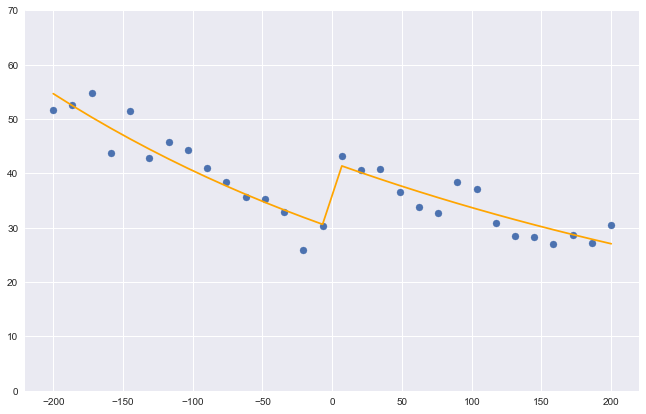

In [323]:
#Lets plot the data which is some true exponential function contaminated with noise
plt.subplots(figsize=(11,7))
plt.scatter(T,Y)
plt.ylim(0,70)

#Now, lets plot the true function. This is what we want our interrupted time series model to discover.
plt.plot(T,F, color='orange')

(2, 4.5)

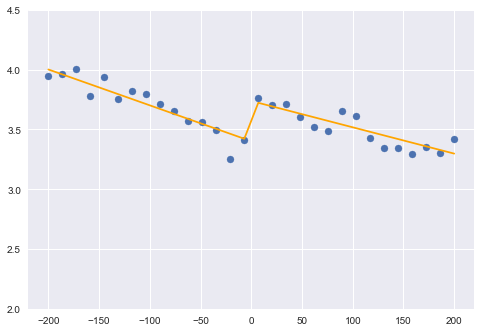

In [324]:
#Now that we have our synthetic data all set up. Lets build our interrupted time series and see if we can discover
#the data generating process.
#As per the slides we have already identify the model as having an exponential form, so we can start by taking the logarithm of our outcome variable
log_F = np.log(F)
log_Y = np.log(Y)
plt.scatter(T,log_Y)
plt.plot(T,log_F,c='orange')
plt.ylim(2,4.5)

In [325]:
#There are two additional variables we need to create to perform the interrupted time series regression with both a level and slope change
#We need the dummy variable X and X*T
X =  [ 0 if x < 0 else 1 for x in T]
XT = X*T

In [380]:
#I like working with dataframes, so lets put our data into one.
df = pd.DataFrame(data={'Y':log_Y[0],'T':T,'X':X,'XT':XT})

In [381]:
#A linear model with an intercept term, β_0, requires a vector of 1's. Lets use statsmodels' add_constant function to add one to our dataframe and call it exog
exog = sm.add_constant(df[['T','X','XT']])

                            OLS Regression Results                            
Dep. Variable:                      Y   R-squared:                       0.876
Model:                            OLS   Adj. R-squared:                  0.862
Method:                 Least Squares   F-statistic:                     61.47
Date:                Wed, 03 Apr 2019   Prob (F-statistic):           6.16e-12
Time:                        12:26:45   Log-Likelihood:                 35.186
No. Observations:                  30   AIC:                            -62.37
Df Residuals:                      26   BIC:                            -56.77
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.3662      0.042     80.902      0.0

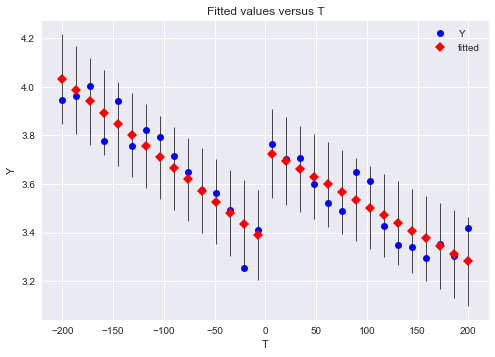

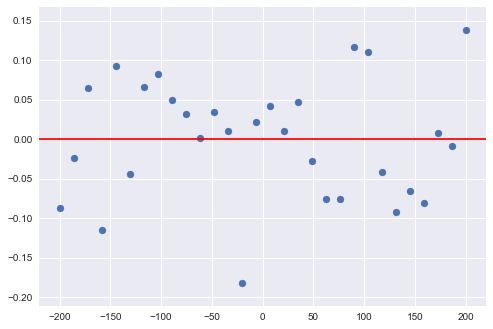

In [382]:
#Now, lets run an OLS regression with our data
model_ols = sm.OLS(endog=df.Y,exog=exog).fit()
print(model_ols.summary())
sm.graphics.plot_fit(model_ols,1)
plt.show()
plt.scatter(T,model_ols.resid)
plt.axhline(y=0,c='r')
plt.show()

In [383]:
#Note that we don't find statistical significance for the change in trend variable, even though one exists of .0008

                    Robust linear Model Regression Results                    
Dep. Variable:                      Y   No. Observations:                   30
Model:                            RLM   Df Residuals:                       26
Method:                          IRLS   Df Model:                            3
Norm:                          HuberT                                         
Scale Est.:                       mad                                         
Cov Type:                          H2                                         
Date:                Wed, 03 Apr 2019                                         
Time:                        12:26:55                                         
No. Iterations:                    29                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.3873      0.044     76.619      0.0

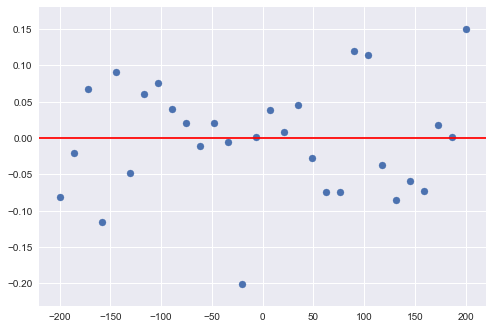

In [386]:
#Now lets do a robust linear model with Huber's T and H2 standard errors
model_rlm = sm.RLM(endog=df.Y,exog=exog).fit(cov='H2')
print(model_rlm.summary())
plt.show()
plt.scatter(T,model_rlm.resid)
plt.axhline(y=0,c='r')
plt.show()

(0, 60)

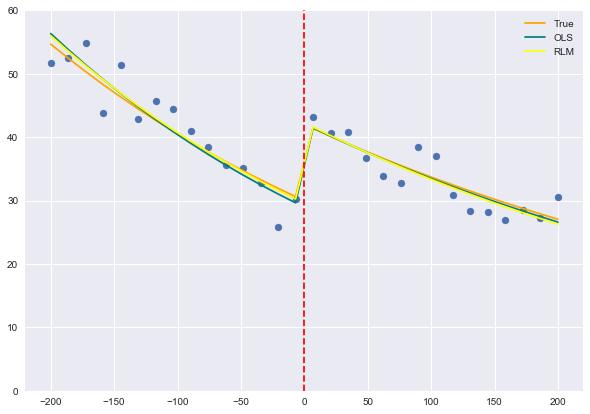

In [385]:
#Lets compare the regression fits to the actual
plt.subplots(figsize=(10,7))
plt.scatter(T,Y)
plt.plot(T,F, c='orange', label='True')
plt.plot(T,np.exp(model_ols.predict()),c='teal',label='OLS')
plt.plot(T,np.exp(model_rlm.predict()),c='yellow',label='RLM')
plt.legend()
plt.axvline(x=0,linestyle='--', c='r')
plt.ylim(0,60)

### Now lets add some outliers

In [449]:
df2=df.append({'Y':4.5,'T':-214,'X':0,'XT':0},ignore_index=True)
df2=df2.append({'Y':1.1,'T':240,'X':1,'XT':240},ignore_index=True).sort_values(by='T').reset_index()

In [450]:
df2

,index,Y,T,X,XT
0,30,4.500000,-214.000000,0.0,0.000000
1,0,3.944432,-200.000000,0.0,-0.000000
2,1,3.960912,-186.206897,0.0,-0.000000
3,2,4.004718,-172.413793,0.0,-0.000000
4,3,3.778001,-158.620690,0.0,-0.000000
5,4,3.940330,-144.827586,0.0,-0.000000
6,5,3.757541,-131.034483,0.0,-0.000000
7,6,3.822099,-117.241379,0.0,-0.000000
8,7,3.792440,-103.448276,0.0,-0.000000
9,8,3.713654,-89.655172,0.0,-0.000000


In [451]:
exog2 = sm.add_constant(df2[['T','X','XT']])
print(exog2)

    const           T    X          XT
0     1.0 -214.000000  0.0    0.000000
1     1.0 -200.000000  0.0   -0.000000
2     1.0 -186.206897  0.0   -0.000000
3     1.0 -172.413793  0.0   -0.000000
4     1.0 -158.620690  0.0   -0.000000
5     1.0 -144.827586  0.0   -0.000000
6     1.0 -131.034483  0.0   -0.000000
7     1.0 -117.241379  0.0   -0.000000
8     1.0 -103.448276  0.0   -0.000000
9     1.0  -89.655172  0.0   -0.000000
10    1.0  -75.862069  0.0   -0.000000
11    1.0  -62.068966  0.0   -0.000000
12    1.0  -48.275862  0.0   -0.000000
13    1.0  -34.482759  0.0   -0.000000
14    1.0  -20.689655  0.0   -0.000000
15    1.0   -6.896552  0.0   -0.000000
16    1.0    6.896552  1.0    6.896552
17    1.0   20.689655  1.0   20.689655
18    1.0   34.482759  1.0   34.482759
19    1.0   48.275862  1.0   48.275862
20    1.0   62.068966  1.0   62.068966
21    1.0   75.862069  1.0   75.862069
22    1.0   89.655172  1.0   89.655172
23    1.0  103.448276  1.0  103.448276
24    1.0  117.241379  1.

/Users/justinclark/anaconda/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


                            OLS Regression Results                            
Dep. Variable:                      Y   R-squared:                       0.595
Model:                            OLS   Adj. R-squared:                  0.552
Method:                 Least Squares   F-statistic:                     13.71
Date:                Wed, 03 Apr 2019   Prob (F-statistic):           1.09e-05
Time:                        12:56:44   Log-Likelihood:                -9.4682
No. Observations:                  32   AIC:                             26.94
Df Residuals:                      28   BIC:                             32.80
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.3180      0.174     19.058      0.0

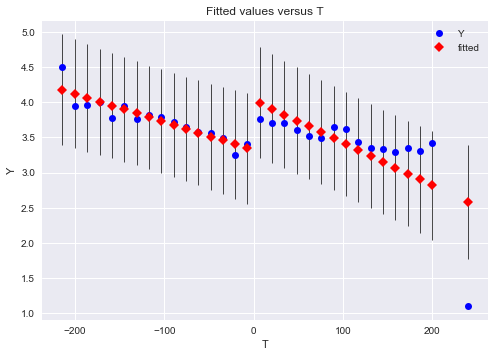

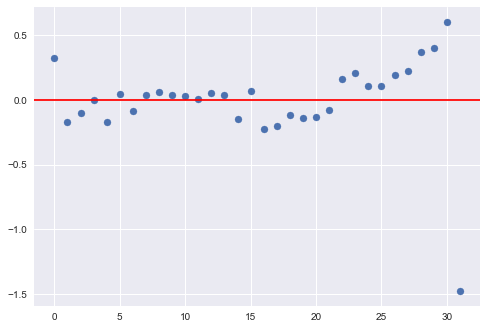

In [452]:
#Now, lets run an OLS regression with our data
model_ols2 = sm.OLS(endog=df2.Y,exog=exog2).fit()
print(model_ols2.summary())
sm.graphics.plot_fit(model_ols2,1)
plt.show()
plt.scatter(range(len(model_ols2.resid)),model_ols2.resid)
plt.axhline(y=0,c='r')
plt.show()

                    Robust linear Model Regression Results                    
Dep. Variable:                      Y   No. Observations:                   32
Model:                            RLM   Df Residuals:                       28
Method:                          IRLS   Df Model:                            3
Norm:                      AndrewWave                                         
Scale Est.:                       mad                                         
Cov Type:                          H2                                         
Date:                Wed, 03 Apr 2019                                         
Time:                        12:56:44                                         
No. Iterations:                    19                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.3809      0.044     76.954      0.0

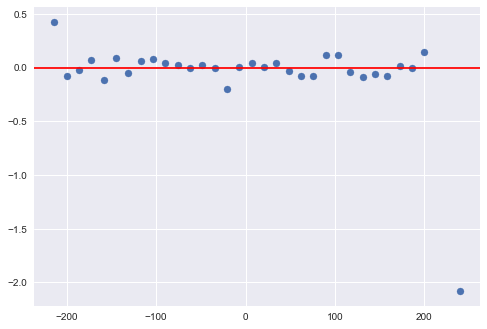

In [453]:
#Now lets do a robust linear model with Huber's T and H2 standard errors
model_rlm2 = sm.RLM(endog=df2.Y,exog=exog2,M=sm.robust.norms.AndrewWave()).fit(cov='H2')
print(model_rlm2.summary())
plt.show()
plt.scatter(df2['T'],model_rlm2.resid)
plt.axhline(y=0,c='r')
plt.show()

(0, 100)

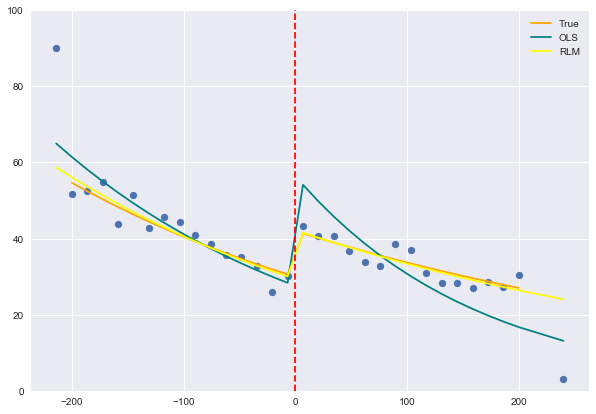

In [454]:
#Lets compare the regression fits to the actual
plt.subplots(figsize=(10,7))
plt.scatter(df2['T'].values,np.exp(df2['Y'].values))
plt.plot(T,F, c='orange', label='True')
plt.plot(df2['T'].values,np.exp(model_ols2.predict()),c='teal',label='OLS')
plt.plot(df2['T'].values,np.exp(model_rlm2.predict()),c='yellow',label='RLM')
plt.legend()
plt.axvline(x=0,linestyle='--', c='r')
plt.ylim(0,100)